In [669]:
#Sep 2024
#Simon Hardy
#Title: Efficiency of Medieval Farming

#pip install geopandas
#pip install os-grid-reference
#pip install statsmodels

%reset -f
import pandas as pd
from pathlib import Path

import geopandas as gpd
from shapely.geometry import Polygon
import osgb

import numpy as np
import statsmodels.formula.api as smf


In [671]:
#CALL THE ORIGINAL DATASHEETS SEPARATELY FOR TESTING
#test1 =pd.read_table(path+"domesday_statistics_by_place.tab", sep='\t', encoding='unicode_escape', low_memory=False, lineterminator='\r', header=(0))
#test2 =pd.read_table(path+"domesday_statistics_livestock.tab", sep='\t', encoding='unicode_escape', low_memory=False, lineterminator='\r', header=(0))
#test3 =pd.read_table(path+"domesday_statistics_manors.tab", sep='\t', encoding='unicode_escape', low_memory=False, lineterminator='\r', header=(0))

In [673]:
#DATA IMPORTS, MERGING DATASHEETS

#specifying where datasheets are, which files should be called, and which columns I want to drop.
path = "/Users/simon/PycharmProjects/HelloWorld/HelloWorld/domesday/"
files = ("domesday_statistics_by_place", "domesday_statistics_livestock","domesday_statistics_manors")

drop_from_domesday_statistics_by_place = ["place_id",
"sub_idx",
"hundred",
"vill",
"m_type",
"holding",
"units",
"waste_86",
"places_idx",
"phillimore_with_new_yks",
"county_name",
"country"]

drop_from_domesday_statistics_livestock = ["cobs_1066",
"county",
"phillimore",
"cattle_1066",
"cows_1066",
"pigs_1066",
"sheep_1066",
"goats_1066",
"beehives_1086",
"beehives_1066",
"wild_mares_1086",
"wild_mares_1066",
"other_1086",
"other_code_1086",
"other_1066",
"other_code_1066"]

drop_from_domesday_statistics_manors = ["head_of_manor",
"county",
"phillimore",
"geld",
"g_code",
"vill_tax",
"taxed_on",
"lords_geld",
"new_land",
"p_code",
#"lords_ploughs_possible",
#"mens_ploughs_possible",
#"total_ploughs_possible",
#"priests",
#"other_pop",
#"misc_pop",
"misc_pop_categories",
#"burgesses",
"mill_value",
"payments",
"payments_units",
"churches",
"value_66",
"value_qr",
"values",
"render",
"waste",
"waste_66",
"waste_qr"]



#call each datasheet, drop unnecessary columns, merge into one datasheet.
for file in files:
    temp_df = pd.read_table(path + file + ".tab", sep='\t', encoding='unicode_escape', low_memory=False, lineterminator='\r', header=(0))
    temp_df = temp_df.drop(eval("drop_from_"+file), axis=1)
    #making sure the index is formatted the same in each datasheet:
    temp_df['struct_idx'] = temp_df['struct_idx'].astype(str)
    temp_df['struct_idx'] = temp_df['struct_idx'].str.extract('(\d+)', expand=False)
    
    try:
        df = df.merge(temp_df, how="outer",on="struct_idx")
    except NameError:
        df = temp_df


del temp_df 



In [675]:
#OBTAINING LAND FERTILITY DATA

#Ordinance Survey:
#osgb is user library for turning os grid squares into EPSG:27700 northing/easting coordinates. Used for creating holding location polygons.
#osgb documentation: https://grid-banger.readthedocs.io/en/latest/API.html

#ALC data:
#ALC grades land in modern england according to agricultural potential, 1=best, 5=worst.
#Criteria include climate (temperature, rainfall, aspect, exposure, frost risk), site (gradient, micro-relief, flood risk) and soil.
#Data available at: https://www.data.gov.uk/dataset/c002ceea-d650-4408-b302-939e9b88eb0b/agricultural-land-classification-alc-grades-post-1988-survey-polygons
#use ne_agl_grades_post_1988_survey_england_download > ESRI shape file

#Isolate grid square info.
gdf_grid = df[['struct_idx', 'grid']].set_index(['struct_idx'])

gdf_grid = gdf_grid.dropna(subset=['grid'])
gdf_grid = gdf_grid[gdf_grid['grid'].str.len()==6]


def os_grid_to_polygon(grid_ref):
    # Use parse_grid to get the easting and northing for the bottom-left corner
    easting, northing = osgb.gridder.parse_grid(grid_ref)
    
    # Define a 1 km by 1 km polygon based on this easting and northing
    polygon = Polygon([
        (easting, northing),                     # Bottom-left corner
        (easting + 1000, northing),              # Bottom-right corner
        (easting + 1000, northing + 1000),       # Top-right corner
        (easting, northing + 1000),              # Top-left corner
        (easting, northing)                      # Close the polygon
    ])
    
    return polygon



# Apply the function to create the geometries
gdf_grid['geometry'] = gdf_grid['grid'].apply(os_grid_to_polygon)

# Convert the DataFrame to a GeoDataFrame
gdf_grid = gpd.GeoDataFrame(gdf_grid, geometry='geometry', crs="EPSG:27700")  # EPSG:27700 is the CRS for British National Grid

# APPLY BUFFER TO GRID SQUARE (3km). Make sure we return an answer.
gdf_grid['geometry'] = gdf_grid['geometry'].buffer(3000)  


# Load ALC data (assuming it's in a compatible format)
gdf_alc = gpd.read_file(path + 'ALC_Grades_(Post_1988)___ADAS_&_Defra.shp')

# Perform the spatial join between the grid squares and the ALC data
gdf_joined = gpd.sjoin(gdf_grid, gdf_alc, how="left", predicate="intersects")

# Filter out rows with unwanted ALC grades before calculating the mode
gdf_filtered = gdf_joined[~gdf_joined['ALC_GRADE'].isin(['Not Surveyed', 'none', 'Other']) & gdf_joined['ALC_GRADE'].notna()]

#Calculate modal ALC
gdf_alc_mode = gdf_filtered.groupby('struct_idx')['ALC_GRADE'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()




# Merge the modal ALC back into the original DataFrame
df = df.merge(gdf_alc_mode, on='struct_idx', how='left')

# Rename the new column
df.rename(columns={'ALC_GRADE': 'fertility'}, inplace=True)


#FOR HOLDINGS WHERE NO ALC_CLASSIFICATION CAN BE FOUND WITHIN BUFFER (3km), FIND NEAREST ALC_GRADE, TO A MAXIMUM OF 10km.
#consideration: now I am mixing methods for attributing ALC_grades to holdings.
#could only use modal ALC grade within 3km, in which case about 10k holdings have none.
#don't want to increase buffer range since this averages out data.
#could also use only nearest ALC grade, but then there's risk of idiosyncratic results.


# Step 1: Identify holdings with NaN fertility values after the join
gdf_grid = gdf_grid.reset_index('struct_idx')
unmatched_holdings = gdf_grid[~gdf_grid['struct_idx'].isin(gdf_alc_mode['struct_idx'])]

# Step 2: Perform a nearest neighbor join for unmatched holdings
# Using gdf_alc that excludes unwanted categories
valid_alc = gdf_alc[~gdf_alc['ALC_GRADE'].isin(['Not Surveyed', 'none', 'Other'])]

# Perform the nearest join with max distance of 10 km
nearest_matches = gpd.sjoin_nearest(
    unmatched_holdings, valid_alc[['geometry', 'ALC_GRADE']], distance_col="distance", max_distance=10000, how="left"
)

# Step 3: Prepare nearest_matches for merging with the original DataFrame
nearest_matches = nearest_matches[['struct_idx', 'ALC_GRADE']].rename(columns={'ALC_GRADE': 'nearest_fertility'})

# Step 4: Merge nearest_matches into df to fill missing fertility values
df = df.merge(nearest_matches, on='struct_idx', how='left')

# Fill NaN values in 'fertility' with 'nearest_fertility' and drop 'nearest_fertility' column afterward
df['fertility'] = df['fertility'].combine_first(df['nearest_fertility'])
df.drop(columns=['nearest_fertility'], inplace=True)


/opt/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/simon/PycharmProjects/HelloWorld/HelloWorld/domesday/ALC_Grades_(Post_1988)___ADAS_&_Defra.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [676]:
#SPATIAL DATA DIAGNOSTIC COMMANDS

#CHECK HOW MANY/WHAT VALUES ARE OUTPUTTED
#df.groupby('fertility').size()
#len(df)-df['fertility'].isna().sum()

#CREATE A MAP, CHECK DISTRIBUTION
#ax = gdf_grid.plot(edgecolor="blue", alpha=0.5, figsize=(8, 8))
#gdf_alc.plot(ax=ax, edgecolor="red", alpha=0.5)

#print(gdf_alc['ALC_GRADE'].value_counts(dropna=False))

#gdf_alc.plot(edgecolor="red",alpha=0.5, figsize=(7,7))

In [677]:
#DROPPING MISSING VALUES/SAMPLING BIAS
#Drop rows that don't have location or value data (most important) and wastes (entries with no economically useful content)

#FIRST: quick binary logistic regression to see if data we are about to drop are associated with any explanatory variables.
df['droper'] = ((df['value_86'].isna()) | (df['waste_86'] == 'Y') | (df['waste_86'] == 'I')).astype(int)
df_test = df[['droper','fertility','ploughlands','total_ploughs','villagers','county']]


log_reg = smf.logit("droper ~ C(fertility) + ploughlands + total_ploughs + villagers", data=df).fit()
print(log_reg.summary())
#CONCLUSION: Fertility, villagers, ploughs/plouglands all correlate. Makes sense, since we are dropping wastelands with no economic output.
#only lowest fertility grade does not correlate. Also makes sense, since many wastes will be in the most infertile places, but not all.

df.groupby('county').droper.sum()
#CONCLUSION: Holdings in little domesday (ESS, NFK, SUF) are being dropped at unusual rates. But still max 1/3 in NFK.
#Why does adding counties (or hundreds) cause multicolinearity?

#Proceed with dropping rows.
df = df[(df['waste_86']!='Y') & (df['waste_86']!='I') & (df['value_86'].notnull())]

#Methodological note: could also impute income (dependent variable). However, as long as excluding it does not cause bias, I don't see how this adds information to the results.



Optimization terminated successfully.
         Current function value: 0.474981
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 droper   No. Observations:                14902
Model:                          Logit   Df Residuals:                    14893
Method:                           MLE   Df Model:                            8
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                 0.05020
Time:                        19:13:31   Log-Likelihood:                -7078.2
converged:                       True   LL-Null:                       -7452.3
Covariance Type:            nonrobust   LLR p-value:                2.963e-156
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.9206      0.226     -8.491      0.000      -2.364

In [678]:
#DEALING WITH UNITS: MEADOWS
#meadows are reported in several units, most importantly 'acres'. Other units are convertible into acres. One county reports in terms of ploughs.

# Conversion factors for length and area: https://www.domesdaybook.net/domesday-book/data-terminology/weights-measures/early-measures
conversion_factors_length = {
    "perches": 1,
    "perch": 1,
    "leagues": 480,   # leagues to perches
    "league": 480,
    "furlongs": 40,   # furlongs to perches
    "furlong": 40,
}

conversion_factors_area = {
    "acres": 1,       # 1 acre = 1 acre
    "acre": 1,
    "hides": 120,     # 1 hide = 120 acres
    "hide": 120,
    "virgates": 30,    # 1 virgate = 30 acres
    "virgate": 30,
}

valid_units = list(conversion_factors_length.keys()) + list(conversion_factors_area.keys())



#NaNs, '-' with nan as value indicates missing.
df.loc[(df['meadow_units'] == "-") & (df['meadow'].isna()), 'meadow_units'] = np.nan
#'-' with units are transfered to mixed measures.
df.loc[
    (df['meadow_units'] == "-") & 
    (df['meadow'].apply(lambda x: any(unit in str(x) for unit in valid_units))),
    'meadow_units'
] = 'mixed measures'


#DUMMY
#some entries only indicate the presence of meadows, but do not contain enough information to know how much.
meadow_dummies = ['just meadow', 'arpents', '-',]
df['meadow_units'] = df['meadow_units'].replace(meadow_dummies, 'dummy')
df.loc[df['meadow_units']=='dummy', 'meadow'] = '1'
#There are not many arpents, and they have an unknown size: https://www.domesdaybook.net/domesday-book/data-terminology/weights-measures/arpent


#ACRES
#one cell is missing a space.
df['meadow'] = df['meadow'].str.replace(r'*2', r'* 2')



#make sure format of cell is always the same by first removing units from the meadows column and then re-adding them in a consistent format.
# Function to clean and standardize units in the dataset
def transform_units(df, values_column, units_column):
    for unit in valid_units:
        mask = df[units_column] == unit
        df.loc[mask, values_column] = (
            df.loc[mask, values_column]
            .astype(str)
            .str.replace(r"[a-zA-Z]", "", regex=True)  # Remove letters
            .str.strip()
            .str.cat([unit] * mask.sum(), sep=" ")  # Append unit
        )
    return df

df = transform_units(df, "meadow", "meadow_units")


# Helper function to check if a string represents a float
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Function to calculate total area in acres, including for holdings that have multiple units. Cells which mix area with ploughs have the ploughs ignored.
# Where only a unit of length is reported (instead of length*length), it is assumed length*1.
def calculate_acres(value_list):
    total_acres = 0  # Running total in acres
    stack = []       # Stack to handle operations and intermediate values

    i = 0
    while i < len(value_list):
        element = value_list[i]

        # Check for NaN and skip it
        if element is None or (isinstance(element, float) and math.isnan(element)):
            print(f"Skipping NaN value at index {i}.")  # Optional debug message
            i += 1
            continue

        # Handle numbers (including floats like "12.5")
        if is_float(element):
            stack.append(float(element))  # Push the numeric value to the stack
        elif element in conversion_factors_length:  # If the element is a length unit
            # Multiply by the unit's value in perches (implicitly multiply by 1 if no number)
            number = stack.pop() if stack else 1
            stack.append(number * conversion_factors_length[element])
        elif element in conversion_factors_area:  # If the element is an area unit
            # Convert directly to acres
            number = stack.pop() if stack else 1
            total_acres += number * conversion_factors_area[element]
        elif element == "*":  # If the element is a multiplication operator
            # Multiply the last two values in the stack
            if len(stack) >= 2:
                b = stack.pop()
                a = stack.pop()
                stack.append(a * b)
        elif element in ["&", "and", "+"]:  # If the element is an addition operator
            # Add the top of the stack to the total acres
            if stack:
                # Convert perches to acres before adding
                total_acres += stack.pop() / 160  # 1 acre = 160 perches
        else:
            i += 1  # Skip unrecognized units
            continue

        i += 1

    # Add any remaining value in the stack to the total (as perches, converted to acres)
    if stack:
        total_acres += stack.pop() / 160  # Convert to acres

    return total_acres


#apply the calculation
# Apply calculate_acres function only to rows with valid units
units_to_replace = valid_units + ["mixed measures"]

df.loc[df["meadow_units"].isin(units_to_replace), "meadow"] = df.loc[
    df["meadow_units"].isin(units_to_replace), "meadow"].apply(
    lambda x: calculate_acres(x.split()) if isinstance(x, str) and x.strip() else np.nan
)

# Update units to 'acres' for valid rows and "mixed measures"
df["meadow_units"] = df["meadow_units"].replace(units_to_replace, "acres")
df['meadow']= df['meadow'].astype(float)



    

/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/1266729602.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['meadow_units'] = df['meadow_units'].replace(meadow_dummies, 'dummy')
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/1266729602.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['meadow'] = df['meadow'].str.replace(r'*2', r'* 2')
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/1266729602.py:137: SettingWithCopyWarning: 
A value is trying to

In [683]:
#DEALING WITH UNITS: PASTURES
#Pastures are reported in several units, most importantly area and different forms of livestock.

#NaN
df.loc[(df['pasture_units'] == "-") & (df['pasture'].isna()), 'pasture_units'] = np.nan
#'-' with units are transfered to mixed measures.
df.loc[
    (df['pasture_units'] == "-") & 
    (df['pasture'].apply(lambda x: any(unit in str(x) for unit in valid_units))),
    'pasture_units'
] = 'mixed measures'

#DUMMY
#some entries cannot be fully evaluated or only indicate the general existance of pastures.
pasture_dummies = ['just pasture', 'grazing for pigs', 'livestock', 'village livestock','value', '-',]
df['pasture_units'] = df['pasture_units'].replace(pasture_dummies, 'dummy')


#LIVESTOCK
#ploughs consist of 8 ox.
df.loc[df['pasture_units'] == 'ploughs', 'pasture'] = (
    df.loc[df['pasture_units'] == 'ploughs', 'pasture']
    .apply(lambda x: float(x) if pd.notna(x) else x)  # Convert only the edited cells to float
    * 8
)
#some entries do not contain enough information to be evaluated, and hence are turned into dummies
livestock_to_dummy = ['1 pig in 7', '1 pig in 6', '1 pig in 3', '1 in 7',]
df.loc[df['pasture'].isin(livestock_to_dummy), 'pasture_units'] = "dummy"
df.loc[df['pasture_units']=='dummy', 'pasture'] = '1'

#combine different forms of livestock
livestock_units_to_replace= ['ploughs','cattle','wether','wethers','sheep','pigs','grazing for pigs',]
df['pasture_units'] = df['pasture_units'].replace(livestock_units_to_replace, 'livestock')



#ACRES
#some data needs to be cleaned out.
pasture_replacements = {
    "less 10 rods": "",
    "less 3 furlongs": "", 
    "& common pasture": "",
    r"& 80 pigs": "",
    r"0.5 league 40 acres long and wide": "0.5 league * 40 acres",
    r"rods" : "perches",
    r"2 * 1 & 5 acres": "2 * 1 acres & 5 acres",
    r'6 * 2 & 20 acres': '6 * 2 acres & 20 acres',
    r"1 league 6 furlongs": "1 league",
    r'4 * 2 & 0.5 * 5.5 l.; 246 a; 1.5 f. & 3 f. * 0.5 l': "8 leagues & 0.5 * 5.5 leagues & 246 acres & 1.5 furlongs & 3 furlongs * 0.4 leagues",

}

for key, value in pasture_replacements.items():
    df['pasture'] = df['pasture'].str.replace(key, value).str.strip()


#apply transformations.
df = transform_units(df, "pasture", "pasture_units")
df.loc[df["pasture_units"].isin(units_to_replace), "pasture"] = df.loc[
    df["pasture_units"].isin(units_to_replace), "pasture"].apply(
    lambda x: calculate_acres(x.split()) if isinstance(x, str) and x.strip() else np.nan
)

# Update units to 'acres' for valid rows and "mixed measures"
df["pasture_units"] = df["pasture_units"].replace(units_to_replace, "acres")
df['pasture']= df['pasture'].astype(float)


/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/2913310106.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pasture_units'] = df['pasture_units'].replace(pasture_dummies, 'dummy')
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/2913310106.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pasture_units'] = df['pasture_units'].replace(livestock_units_to_replace, 'livestock')
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/2913310106.py:54: Setting

In [687]:
#DEALING WITH UNITS: WOODLANDS



#NA
df.loc[(df['woodland_units'] == "-") & (df['woodland'].isna()), 'woodland_units'] = np.nan
#'-' with units are transfered to mixed measures.
df.loc[
    ((df['woodland_units'] == "-") |
    (df['woodland_units'] == "in Forest")) & 
    (df['woodland'].apply(lambda x: any(unit in str(x) for unit in valid_units))),
    'woodland_units'
] = 'mixed measures'


#DUMMY
woodland_dummies = ['pig pastures',
                  'leagues;in Forest',
                  'just woodland',
                  'pigs;in Forest',
                  'swine render;in Forest',
                  'alder wood',
                  'swine render',
                  'arpents',
                  'woodland for fences',
                  'in forest',
                  '-',]

df['woodland_units'] = df['woodland_units'].replace(woodland_dummies, 'dummy')
df.loc[(df['woodland']=='1.5 * 4') & (df['woodland_units']=='mixed measure'), 'woodland_unit'] = 'dummy'
df.loc[(df['woodland_units'] == "in Forest") & (df['woodland'].isna()), 'woodland_units'] = 'dummy'

df.loc[df['woodland_units']=='dummy', 'woodland'] = '1'


#LIVESTOCK
df.woodland_units = df.woodland_units.replace('pigs', 'livestock')

#ACRES
#some manual data cleaning
woodland_replacements = {
    '1 * 0.5 and 46 acres' : '46.5 acres',
    '0.5 league * 0.5 league 1 furlong & 0.5 league * 3 furlongs' : '0.5 league * 7 furlong & 0.5 league * 3 furlongs',
    '6 furlongs 6 perches * 3 furlongs 13 perches' : '246 * 133 perches',
    'less 7 perches' : '',
    'rods' : 'perches',
}
for key, value in woodland_replacements.items():
    df['woodland'] = df['woodland'].str.replace(key, value).str.strip()


#apply transformations.
df = transform_units(df, "woodland", "woodland_units")
df.loc[df["woodland_units"].isin(units_to_replace), "woodland"] = df.loc[
    df["woodland_units"].isin(units_to_replace), "woodland"].apply(
    lambda x: calculate_acres(x.split()) if isinstance(x, str) and x.strip() else np.nan
)

# Update units to 'acres' for valid rows and "mixed measures"
df["woodland_units"] = df["woodland_units"].replace(units_to_replace, "acres")
df['woodland']= df['woodland'].astype(float)

/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/3897773925.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['woodland_units'] = df['woodland_units'].replace(woodland_dummies, 'dummy')
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/3897773925.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df['woodland']=='1.5 * 4') & (df['woodland_units']=='mixed measure'), 'woodland_unit'] = 'dummy'
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_5770/38977739

In [526]:
#UNITS TESTING CODE
#df.woodland_units.unique()
#print(df.groupby('pasture_units').pasture_units.count())
#print(df.pasture_units.isna().sum())
#print(df.pasture.isna().sum())

#df[df['woodland_units']=='-'].woodland.unique()d



#Meadow counts:
#acres - 11481
#dummy - 52
#ploughs - 1122
#NaN - 7092 (issue: more NAs in values than units)

#Pasture counts:
#acres - 2649
#dummy - 487
#livestock - 209
#NaN - 16402 (issue: more NAs in values than units)

#Woodland
#acres - 4994
#dummy - 1148
#livestock - 2724
#NaN - 10881 (issue: more NAs in values than units)




pasture_units
acres    2649
dummy     696
Name: pasture_units, dtype: int64
16402
16402


In [110]:
#INSPECTING DATA: OVERVIEW
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100


df_backup = df


df.describe()

,cobs_1086,cattle_1086,cows_1086,pigs_1086,sheep_1086,goats_1086,ploughlands,lords_ploughs,mens_ploughs,total_ploughs,lords_ploughs_possible,mens_ploughs_possible,total_ploughs_possible,villagers,smallholders,slaves,female_slaves,freemen,free_men,priests,cottagers,other_pop,misc_pop,burgesses,mills,fisheries,salthouses,church_land,value_86,droper
count,1813.000000,2835.000000,175.000000,2893.000000,3431.000000,1264.000000,12542.000000,18334.000000,18341.000000,19479.000000,596.000000,673.000000,989.000000,19737.000000,19736.000000,19734.000000,19736.000000,19732.000000,19736.000000,19734.000000,19736.000000,19737.000000,19734.000000,19707.000000,5236.000000,865.000000,462.000000,1326.000000,19747.000000,19747.0
mean,2.130723,10.241270,2.668571,21.483927,111.262314,27.844937,7.868909,1.672593,4.725655,6.127794,1.077181,2.044577,3.160768,8.306911,6.127052,2.160636,0.062424,1.677529,1.040282,0.088046,0.295703,0.160865,0.422773,0.449637,1.626524,2.261711,3.860325,0.495595,5.657324,0.0
std,1.716692,10.541831,2.145266,22.520334,147.699676,20.786735,12.592155,2.260313,10.249153,11.268893,1.270512,3.269553,4.823760,17.150225,12.193275,6.394855,0.672794,9.313354,4.664007,0.412013,2.490644,1.600445,3.819841,8.804226,1.557941,3.278237,8.004476,0.756995,12.753217,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,4.000000,1.000000,8.000000,32.000000,13.000000,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.100000,0.650000,0.0
50%,2.000000,7.000000,2.000000,15.000000,65.000000,24.000000,4.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,1.000000,0.250000,2.000000,0.0
75%,2.000000,13.000000,4.000000,30.000000,124.000000,37.000000,8.000000,2.000000,5.000000,7.000000,1.500000,2.000000,3.000000,9.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000,0.575000,5.000000,0.0
max,15.000000,140.000000,11.000000,200.000000,1600.000000,199.000000,185.000000,30.500000,192.000000,197.000000,10.000000,36.000000,92.000000,309.000000,480.000000,136.000000,15.000000,204.000000,90.000000,30.000000,100.000000,60.000000,202.000000,720.000000,17.000000,63.000000,100.000000,8.000000,305.750000,0.0


In [111]:
#INSPECTING DATA: NAs
#There are many NAs due to the inconsistency of scribes. This can be dealt with, as inconsistencies are random or highly correlated with county.
#However, it also appears that 0 values were more likely to go unrecorded.
#The database's creators have inserted 0 when an absence is the scribe's convention for 0. But only for populations and ploughteams.
#NOT for ploughlands, valuations, geld, mills/other appurtenances.

#Hence must decide for each variable if it is appropriate to assume all NA=0, or if we can impute the values for NA. 3 criteria for first route:
#1. Variable has many missing entries.
#2. Variable does not have many (or any) 0 values.
#3. Histogram suggests we should expect many 0 values.

#1. TABLE SHOWING FRACTION OF NAs IN EACH COLUMN BROKEN UP BY COUNTY
livestock_counties = ['SOM', 'DOR', 'DEV', 'CON', 'ESS', 'NFK', 'SUF']
df[df['county'].isin(livestock_counties)].isnull().groupby(df.county).mean().style.background_gradient(axis=None) 


#NOTES:
#Livestock data only available for circuit 2 (exeter domesday - CON, DEV, DOR, SOM) and circuit 7 (little domesday - ESS, NFK, SUF).
#No ploughlands data for circuit 7 (little domesday - ESS, NFK, SUF).
#very little data on 'ploughs possible' except in a few counties.
#significant missing data for mills, woodland, meadows, livestock, fisheries, salthouses, church land
#almost no data for pastures except in circuits 2 and 7 and a few others.

,struct_idx,county,phillimore,area,std_hundred,std_vill,grid,cobs_1086,cattle_1086,cows_1086,pigs_1086,sheep_1086,goats_1086,ploughlands,lords_ploughs,mens_ploughs,total_ploughs,lords_ploughs_possible,mens_ploughs_possible,total_ploughs_possible,villagers,smallholders,slaves,female_slaves,freemen,free_men,priests,cottagers,other_pop,misc_pop,burgesses,mills,meadow,meadow_units,pasture,pasture_units,woodland,woodland_units,fisheries,salthouses,church_land,value_86,waste_86,duplicates,subholdings,notes,fertility,droper
county,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CON,0.000000,0.000000,0.000000,0.994100,0.000000,0.000000,0.008850,0.964602,0.445428,0.911504,0.749263,0.280236,0.793510,0.011799,0.029499,0.029499,0.008850,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.985251,0.808260,0.000000,0.085546,0.000000,0.404130,0.000000,1.000000,0.997050,1.000000,0.000000,0.000000,0.000000,0.000000,0.398230,0.008850,0.000000
DEV,0.000000,0.000000,0.000000,0.996000,0.000000,0.000000,0.030400,0.872000,0.374400,0.988800,0.620000,0.298400,0.688800,0.024800,0.039200,0.039200,0.012800,1.000000,1.000000,1.000000,0.000000,0.000000,0.000800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.909600,0.168800,0.000000,0.256000,0.000000,0.305600,0.000000,0.985600,0.979200,0.988000,0.000000,0.000000,0.000000,0.000000,0.149600,0.057600,0.000000
DOR,0.000000,0.000000,0.000000,0.994565,0.000000,0.000000,0.094203,0.815217,0.871377,0.969203,0.788043,0.751812,0.900362,0.059783,0.086957,0.086957,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592391,0.221014,0.000000,0.273551,0.000000,0.487319,0.000000,0.998188,0.996377,0.980072,0.000000,0.000000,0.000000,0.000000,0.679348,0.090580,0.000000
ESS,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.218623,0.625506,0.580972,0.946356,0.525304,0.497976,0.845142,1.000000,0.141700,0.142713,0.006073,0.976721,0.982794,0.966599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002024,0.000000,0.000000,0.000000,0.000000,0.756073,0.356275,0.000000,0.793522,0.000000,0.332996,0.000000,0.949393,0.967611,0.986842,0.000000,0.000000,0.000000,0.000000,0.677126,0.216599,0.000000
NFK,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.089842,0.720776,0.721797,0.994895,0.603880,0.647269,0.872894,0.999490,0.027565,0.027565,0.000000,0.956611,0.965288,0.916794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.648290,0.171006,0.000000,0.989280,0.000000,0.570699,0.000000,0.937723,0.928025,0.771822,0.000000,0.000000,0.000000,0.000000,0.608984,0.102093,0.000000
SOM,0.000000,0.000000,0.000000,0.982256,0.000000,0.000000,0.013942,0.602028,0.461343,0.941698,0.378961,0.370089,0.787072,0.044360,0.036755,0.036755,0.022814,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.599493,0.166033,0.000000,0.420786,0.000000,0.316857,0.000000,0.975919,1.000000,0.983523,0.000000,0.000000,0.000000,0.000000,0.166033,0.031686,0.000000
SUF,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.102551,0.840187,0.786569,0.997397,0.749610,0.745966,0.906299,1.000000,0.042166,0.031234,0.000000,0.989589,0.992192,0.986465,0.000000,0.000000,0.000521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.872462,0.370120,0.000000,0.999479,0.000000,0.748048,0.000000,0.988027,0.986986,0.757418,0.000000,0.000000,0.000000,0.000000,0.730349,0.098907,0.000000


In [112]:
#INSPECTING DATA: PRESENCE OF 0s

#TABLE SHOWING FRACTION OF VALUES THAT EQUAL 0.
dft=df[df['county'].isin(livestock_counties)]
(dft[dft==0].groupby(dft.county).count()/dft.groupby(dft.county).count()).style.background_gradient(axis=None) 

#The presence of 0 values gives me confidence that remaining 0-values can be imputed.
#Where 0 values are totally absent, it's more plausible to assume all NAs are 0.


#data with no zeros:
#all livestock in circuit 2. [can be imputed from other counties]
#Church land [drop], mills [probably fill 0s], fisheries, ploughlands [probably fine] in most counties.
#Meadows, salthouses, woodland, pastures in all. [assume 0]


,area,burgesses,cattle_1086,church_land,cobs_1086,cottagers,county,cows_1086,droper,duplicates,female_slaves,fertility,fisheries,free_men,freemen,goats_1086,grid,lords_ploughs,lords_ploughs_possible,meadow,meadow_units,mens_ploughs,mens_ploughs_possible,mills,misc_pop,notes,other_pop,pasture,pasture_units,phillimore,pigs_1086,ploughlands,priests,salthouses,sheep_1086,slaves,smallholders,std_hundred,std_vill,struct_idx,subholdings,total_ploughs,total_ploughs_possible,value_86,villagers,waste_86,woodland,woodland_units
county,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CON,0.000000,0.997050,0.000000,nan,0.000000,1.000000,nan,0.000000,1.000000,0.000000,1.000000,0.000000,nan,1.000000,1.000000,0.000000,0.000000,0.194529,nan,0.000000,0.000000,0.264438,nan,0.000000,0.932153,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.185841,0.076696,0.000000,0.000000,0.000000,0.000000,0.130952,nan,0.000000,0.309735,0.000000,0.000000,0.000000
DEV,0.000000,0.991994,0.000000,0.000000,0.000000,0.995200,nan,0.000000,1.000000,0.000000,0.999200,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.142381,nan,0.000000,0.000000,0.139883,nan,0.000000,0.976800,0.000000,0.931200,0.000000,0.000000,0.000000,0.000000,0.000000,0.999200,0.000000,0.000000,0.186549,0.217600,0.000000,0.000000,0.000000,0.000000,0.061588,nan,0.000000,0.107200,0.000000,0.000000,0.000000
DOR,0.000000,0.990942,0.000000,0.000000,0.000000,0.918478,nan,0.000000,1.000000,0.000000,0.998188,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.271825,nan,0.000000,0.000000,0.400794,nan,0.000000,0.952899,0.000000,0.940217,0.000000,0.000000,0.000000,0.000000,0.000000,0.996377,0.000000,0.000000,0.362319,0.284420,0.000000,0.000000,0.000000,0.000000,0.201087,nan,0.000000,0.346014,0.000000,0.000000,0.000000
ESS,nan,0.992915,0.014493,0.000000,0.051351,1.000000,nan,0.075472,1.000000,0.000000,1.000000,0.000000,0.240000,0.914980,0.899798,0.045752,0.000000,0.162736,0.260870,0.000000,0.000000,0.330579,0.529412,0.099585,0.983806,0.000000,1.000000,0.000000,0.000000,0.000000,0.017058,nan,0.969574,0.000000,0.010081,0.450405,0.189271,0.000000,0.000000,0.000000,0.000000,0.113035,0.000000,0.000000,0.459514,0.000000,0.000000,0.000000
NFK,nan,0.996427,0.012844,0.022371,0.012797,1.000000,nan,0.000000,1.000000,0.000000,1.000000,0.000000,0.040984,0.398162,0.526289,0.024096,0.000000,0.436745,0.082353,0.000000,0.000000,0.107087,0.117647,0.027576,0.976519,0.000000,1.000000,0.000000,0.000000,0.000000,0.009021,0.000000,0.988259,0.021277,0.010130,0.681470,0.221542,0.000000,0.000000,0.000000,0.000000,0.080143,0.006135,0.000510,0.478305,0.000000,0.000000,0.000000
SOM,0.000000,0.969582,0.000000,0.000000,0.000000,0.902408,nan,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.998733,0.000000,0.000000,0.125000,nan,0.000000,0.000000,0.203947,nan,0.000000,0.944233,0.000000,0.954373,0.000000,0.000000,0.000000,0.000000,0.001326,0.996198,nan,0.000000,0.262357,0.115336,0.000000,0.000000,0.000000,0.000000,0.071336,nan,0.000000,0.197719,0.000000,0.000000,0.000000
SUF,nan,0.995315,0.034146,0.010730,0.039088,1.000000,nan,0.000000,1.000000,0.000000,1.000000,0.000000,0.260870,0.293597,0.920875,0.011111,0.000000,0.667391,0.050000,0.000000,0.000000,0.293391,0.400000,0.053061,0.993753,0.000000,1.000000,0.000000,0.000000,0.000000,0.014553,nan,0.996877,0.160000,0.018443,0.830729,0.471629,0.000000,0.000000,0.000000,0.000000,0.246226,0.000000,0.000000,0.761583,0.000000,0.000000,0.000000


In [117]:
#INSPECTING DATA: Appurtenances
#parts of the manor.

#mills: https://www.domesdaybook.net/domesday-book/data-terminology/manors/mills
#domesday records 99% of mills known to have existed in that century. >6000 recorded. Very economically important.
#dataset includes mill value (monetary), but I'm not using it for now.
#df['mills'].hist(bins=35)
#df.groupby('mills').count()
#IMPLIES MANY MISSING 0s.

#salthouses: https://www.domesdaybook.net/domesday-book/data-terminology/borough-castle/salt
#likely not systematically recorded.
#df['salthouses'].hist(bins=35)


#fisheries: https://www.domesdaybook.net/domesday-book/data-terminology/manors/fisheries
#common, definitely inconsistent recording.
#df['fisheries'].hist(bins=35)



#meadow: https://www.domesdaybook.net/domesday-book/data-terminology/manors/meadow
#Very important, well recorded. Sometimes recorded in terms of ploughteams-equivalent, otherwise acres.
#consider editing data types?
#df['meadow'].hist(bins=35)



#pasture: https://www.domesdaybook.net/domesday-book/data-terminology/manors/pasture
#very inconsistent, except in circuit 2 (Exeter domesday).
#often recorded in terms of livestock it can support. Otherwise linear measures, etc.
#df['pasture'].hist(bins=35)



#woodland: https://www.domesdaybook.net/domesday-book/data-terminology/manors/woodland
#about 15% of england wooded. Recorded in confusing mix of units. Sometimes definitely inconsistent.
#df['woodland'].hist(bins=35)



/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_16658/373681923.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['lords_and_mens']= df_p[["lords_ploughs","mens_ploughs"]].sum(skipna=False,axis=1)
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_16658/373681923.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['dif_real'] = df_p['lords_and_mens'].sub(df_p['total_ploughs'],fill_value=0)
/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_16658/373681923.py:24: Sett

<Axes: >

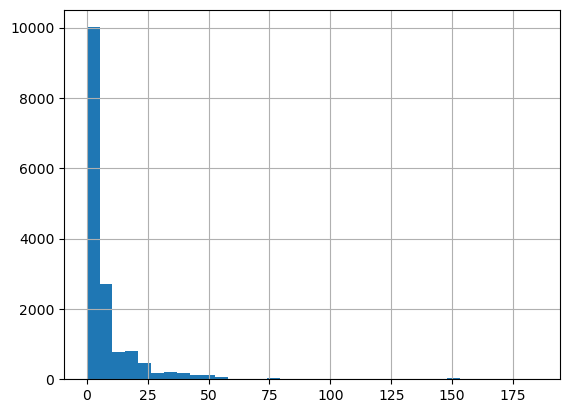

In [65]:
#INSPECTING DATA: PLOUGH LAND/TEAMS
#https://www.domesdaybook.net/domesday-book/data-terminology/weights-measures/ploughlands
#https://www.roffe.co.uk/cornell.htm
#"ploughlands" either a measure of land or a unit of taxation. In domesday it is recorded as "land for so many ploughs".
#Sometimes corresponds perfectly to total number of plough teams, often exceeds it. Sometimes there seem to be too many ploughteams (possibly indicated unassessed land?).
#"additional possible ploughteams" are sometimes recorded.
#In Little Domesday (ESS, NFK, SUF) ploughlands only recorded for county as a whole. Same for parts of other circuits.
#Ploughlands appear to be more 'notional' in the north of england.
#seems to correspond best to "hides" (cleared land area). As opposed to land that was still wild. Seems to have been used to inform taxation level.
#Ploughlands always recored in surviving Domesday inquest records. Appears to have been provided by lords. Hence data was gathered, but often ommitted from Domesday book. Inquest not digitized?
#Later documents use "land for so many ploughs" to assess arable area.

#Looking at the dataset:
#Lord's/men's ploughteams are sometimes not consistent with total ploughteams.
#Possible Lord's/men's ploughteams often don't sum to total possible ploughteams.
#No ploughlands in little domesday.

df_p=df[["lords_ploughs_possible","mens_ploughs_possible","total_ploughs_possible","lords_ploughs","mens_ploughs","total_ploughs","ploughlands"]]

df_p['lords_and_mens']= df_p[["lords_ploughs","mens_ploughs"]].sum(skipna=False,axis=1)
df_p['dif_real'] = df_p['lords_and_mens'].sub(df_p['total_ploughs'],fill_value=0)
#df_p['dif_real'].describe()
#seems to be one entry where there are 31 more total ploughs recorded than sum of mens and lords? Otherwise consistent.
df_p['lords_and_mens_possible']= df_p[["lords_ploughs_possible","mens_ploughs_possible"]].sum(skipna=False,axis=1)
df_p['dif_possible'] = df_p['lords_and_mens_possible'].sub(df_p['total_ploughs_possible'],fill_value=0)
#df_p'dif_possible'].describe()
#Many holdings where there are more total possible ploughteams recorded than sum of mens and lords.

df_p['ploughs_spare_capacity1'] = df_p['total_ploughs_possible'].sub(df_p['total_ploughs'],fill_value=0)
#df_p['ploughs_spare_capacity1'].describe()
#on average, 5.4 more ploughs than possible!? s.d.=12.5.

df_p['land_versus_possible_teams'] = df_p['total_ploughs_possible'].sub(df_p['ploughlands'],fill_value=0)
#df_p['ploughs_spare_capacity2'].describe()
#on average, 7.4 more ploughland than total ploughs possible? s.d.=14.

#DECIDE:
#1. Can use ploughland as measure of cultivated land.
#2. Given high level of correlation, should be able to impute missing values (even for little domesday) using k nearest neighbor.
#3. Excess ploughteams possibly indicating unrecorded land may BIAS COEFFICIENTS.

del df_p

df['ploughlands'].hist(bins=35)


In [53]:
#RESTRICTING DATASET: 3 APPROACHES

#1. Use England data, drops individual entries with too little data.
#Pro: coverage, Con: Some counties have systematically way more data.

#count number of non-NaNs and non-0s among production inputs (for each row):
#df['count_inputs'] = df.count(axis=1) - (df == 0).sum(axis=1) - 11 #there are 11 non-input columns (index, location, value, etc.)

#df.groupby('county').count_inputs.mean().sort_values()

#drop entries with fewer than 4 inputs
#df = df[df['count_inputs']>=4]

#2. [CURRENTLY CHOSEN] Restrict dataset to entries from counties with livestock data.
#Pro: more data per entry, significant coverage. Con: not full coverage.
livestock_counties = ['SOM', 'DOR', 'WIL', 'DEV', 'CON', 'ESS', 'NFK', 'SUF']
df = df[df['county'].isin(livestock_counties)]

#3. Restrict to little domesday. since it has more data and was recorded separately.
#Pro: more data per entry, methodological/sampling consistency. Con: least coverage.
#little_domesday = ['ESS', 'NFK', 'SUF']
#df = df[df['county'].isin(little_domesday)]



In [37]:
df['droper'] = ((df['grid'].isna()) | (df['value_86'].isna()) | (df['waste_86'] == 'Y') | (df['waste_86'] == 'I')).astype(int)
df_test = df[df['droper','fertility','ploughlands','total_ploughs','villagers','county']]
df_test.describe()

/var/folders/wq/93tz19ss0tb00nycxgx5d08h0000gn/T/ipykernel_4737/3935930902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['droper'] = ((df['grid'].isna()) | (df['value_86'].isna()) | (df['waste_86'] == 'Y') | (df['waste_86'] == 'I')).astype(int)


KeyError: ('droper', 'fertility', 'ploughlands', 'total_ploughs', 'villagers', 'county')

In [ ]:
#FILLING REMAINING MISSING VALUES
#Dataset records '0' when it is the scribe's convention to indicate there being nothing by leaving the space blank. Exceptions: ploughlands, value.
#Hence must impute remaining NaNs

#overview of imputing data: http://www.stat.columbia.edu/~gelman/arm/missing.pdf
#imputing methods Sklearn: https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation
#should use sklearn.impute import KNNImputer (nearest neighbor non-parametric imputation). Makes no assumptions about distribution of errors.






In [ ]:
#COMBINE COLUMNS: LIVESTOCK
#https://www.domesdaybook.net/domesday-book/data-terminology/manors/livestock
#https://www.domesdaybook.net/domesday-book/data-terminology/manors/sheep
#little domesday, Exeter domesday, Cambridgeshire (but not CAM in dataset?) record LORD'S livestock (not peasant's).
#Cattle and beasts associated with ploughing. Sometimes exactly equal 8*[total ploughteams].
#Pigs used to measure woodland.

#Drop cattle,

#Cobs=horses. 


#previous paper uses: livestock (sum of cows, swine, sheep, goats); freemen+sokemen; villains; borders; slaves; woodland (measured in swine it could support); meadow (acres); pasture (sheep it could support).



#read up on: cobs, cows, pigs, sheep, goats,

In [41]:
#COMBINE COLUMNS: POPULATION

#https://www.domesdaybook.net/domesday-book/data-terminology/peasantry/villager
#"villagers",	villein', 40% of population. Unfree peasants, 'economically undistinguishable from freemen'. Typically had 30ish acres and two plough oxen.	
#https://www.domesdaybook.net/domesday-book/data-terminology/peasantry/bordar-or-smallholder
#"smallholders",	"bordar" 30% of population. 30% of population. Category began to disappear shortly after domesday.	
#https://www.domesdaybook.net/domesday-book/data-terminology/peasantry/serf
#"slaves",	serfs, 10% of pop. Not recorded for 6th circuit despite being present. Probably work on lord's land. Probably only record heads of household (like with other social groups).	
#"female_slaves",		MERGE WITH SLAVES
#https://www.domesdaybook.net/domesday-book/data-terminology/peasantry/freeman
#"freemen",	sokemen'. 14% of population. On average 30acres and two oxen. Especially common in former danelaw. Declining sharply around this time	
#"free_men",	liberi homines	MERGE WITH FREEMEN
#"priests",	
#https://www.domesdaybook.net/domesday-book/data-terminology/peasantry/cottager
#"cottagers",	only recoreded in 2nd circuit.	MERGE WITH SMALLHOLDERS
#"other_pop",	major groups that are confined to a few counties	
#"misc_pop",		
#"misc_pop_categories",
#"burgesses", basically townspeople. Hard to count.


df['slaves'] = df['slaves']+df['female_slaves']
df = df.drop('female_slaves', axis=1)

df['smallholders'] = df['smallholders']+df['cottagers']
df = df.drop('cottagers', axis=1)

df['freemen'] = df['freemen']+df['free_men']
df = df.drop('free_men', axis=1)

df['freemen_all'] = df['freemen'] + df['smallholders']

df['unfreemen_all'] = df['villagers'] + df['slaves']

df['population'] = df[['freemen_all','unfreemen_all','priests','other_pop','misc_pop','burgesses']].sum(axis=1)

In [43]:
df

,struct_idx,county,phillimore,area,std_hundred,std_vill,grid,cobs_1086,cattle_1086,cows_1086,...,woodland_units,fisheries,salthouses,church_land,value_86,count_inputs,circuit,freemen_all,unfreemen_all,total_population
5,28,KEN,M2,Eastry,Bewsbury,Charlton,TR3142,NaN,NaN,NaN,...,-,NaN,NaN,NaN,3.50,4,1,4.0,3.0,7.0
6,29,KEN,M3,Eastry,Bewsbury,Charlton,TR3142,NaN,NaN,NaN,...,-,NaN,NaN,NaN,6.00,6,1,7.0,1.0,8.0
7,30,KEN,M4,Eastry,Bewsbury,Buckland,TR3042,NaN,NaN,NaN,...,-,NaN,NaN,NaN,4.00,4,1,10.0,6.0,16.0
8,31,KEN,M5,Eastry,Bewsbury,Guston,TR3244,NaN,NaN,NaN,...,-,NaN,NaN,NaN,1.00,4,1,6.0,2.0,8.0
9,32,KEN,M6,Eastry,Bewsbury,St Margarets at Cliffe,TR3544,NaN,NaN,NaN,...,-,NaN,NaN,NaN,5.00,4,1,6.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22930,22851,SUF,"74,13",NaN,Claydon,Whitton,TM1347,NaN,NaN,NaN,...,-,NaN,NaN,0.08,2.01,4,7,30.0,0.0,30.0
22937,22859,SUF,"75,4",NaN,Bishops,Instead,TM2380,NaN,NaN,NaN,...,-,NaN,NaN,NaN,0.10,4,7,2.0,0.0,2.0
22938,22860,SUF,"75,5",NaN,Bishops,Bedingfield,TM1768,NaN,NaN,NaN,...,pigs,NaN,NaN,NaN,0.50,4,7,5.0,0.0,5.0
22945,22869,SUF,"76,7",NaN,Babergh,Cavendish,TL8046,NaN,NaN,NaN,...,pigs,NaN,NaN,NaN,1.00,8,7,8.0,2.0,10.0


In [179]:
df.describe()

,cobs_1086,cattle_1086,cows_1086,pigs_1086,sheep_1086,goats_1086,ploughlands,lords_ploughs,mens_ploughs,total_ploughs,...,freemen,mills,fisheries,salthouses,church_land,value_86,count_inputs,freemen_all,unfreemen_all,total_population
count,803.000000,1601.00000,121.000000,1422.000000,1906.000000,682.000000,8732.000000,10551.000000,10547.000000,11014.000000,...,11013.000000,3179.000000,416.000000,214.000000,369.000000,11014.000000,11014.000000,11013.000000,11012.000000,11011.000000
mean,1.722291,9.27920,2.371901,16.428973,84.806925,24.010264,5.881718,1.568805,3.768929,5.184550,...,1.068737,1.378663,1.889976,3.282664,0.461637,4.696595,7.310605,6.331154,9.605839,15.935746
std,1.404957,9.54025,1.902333,16.876467,104.641312,19.805031,7.637022,1.408432,5.809726,6.580768,...,4.184721,1.074822,2.180871,4.921589,0.884252,8.661832,2.408828,8.444410,12.771597,18.021012
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
25%,1.000000,4.00000,1.000000,6.000000,30.000000,11.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,1.000000,1.000000,1.000000,0.100000,1.000000,5.250000,2.000000,2.000000,6.000000
50%,1.000000,7.00000,2.000000,12.000000,58.000000,20.000000,4.000000,1.000000,2.000000,3.000000,...,0.000000,1.000000,1.000000,1.000000,0.200000,2.000000,7.000000,4.000000,6.000000,11.000000
75%,2.000000,12.00000,3.000000,20.000000,100.000000,30.000000,7.000000,2.000000,5.000000,6.000000,...,0.000000,1.500000,2.000000,4.000000,0.500000,5.000000,9.000000,8.000000,12.000000,20.000000
max,15.000000,140.00000,11.000000,160.000000,1037.000000,199.000000,185.000000,19.000000,172.000000,185.000000,...,90.000000,12.000000,31.000000,39.000000,8.000000,154.050000,16.000000,106.000000,304.000000,377.000000


In [181]:
%whos DataFrame

Variable    Type         Data/Info
----------------------------------
df          DataFrame          struct_idx county p<...>[11014 rows x 36 columns]
df_backup   DataFrame          struct_idx county p<...>[22967 rows x 36 columns]


In [183]:
#NEXT STEPS:
#1. Deal with different units.
#2. Try imputing missing values, produce histograms and see if realistic number of 0s created.
#2. Create geospatial dataset with 0s. Try graphing basic data on map of england.
#3. Basic production function estimation (probably just standard trans-log model).
#4. Conduct Data Envelopment Analysis (DEA) for measuring allocative/productive efficiency. Requires further reading:
#https://en.wikipedia.org/wiki/Data_envelopment_analysis
#https://economics.uq.edu.au/files/30481/WP092021.pdf
#https://academic.oup.com/book/8538/chapter-abstract/154402116?redirectedFrom=fulltext&login=false
#https://books.google.at/books?hl=en&lr=&id=PBITDAAAQBAJ&oi=fnd&pg=PR11&dq=Fried+et+al+(2008)&ots=5sW3gBEwLh&sig=pZYMJ5q5cHaNtQmqDq5knd8pmLc&redir_esc=y#v=onepage&q=Fried%20et%20al%20(2008)&f=false


#NOTES:
#Boroughs datasets contain information on towns/villages. However, data is apparently not standardized enough for statistical analysis.
#Could also call in datasheets on feudal structure in order to derive the number of overlords, or the tenant-in-chief's total number of holdings. Very secondary.

